In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from fpdf import FPDF

from sklearn.model_selection import train_test_split
from keras import layers,models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Verificar si TensorFlow detecta GPU
import tensorflow as tf
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Configurar para usar la GPU si está disponible
if tf.config.experimental.list_physical_devices('GPU'):
    # Limitar la cantidad de VRAM a utilizar si es necesario
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

In [4]:
#df = pd.read_pickle('3Emociones.pkl')
df = pd.read_pickle('3Emociones.pkl')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4623 entries, 0 to 4622
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Imagen           4623 non-null   object
 1   Imagen con zoom  4623 non-null   object
 2   Hitos faciales   4623 non-null   object
 3   Etiquetas        4623 non-null   object
dtypes: object(4)
memory usage: 180.6+ KB


In [6]:
df.head()

,Imagen,Imagen con zoom,Hitos faciales,Etiquetas
0,"[[165, 166, 164, 167, 167, 166, 167, 167, 167,...","[[161, 160, 161, 161, 161, 161, 161, 160, 99, ...","[[62, 83], [62, 88], [63, 93], [63, 97], [64, ...",bored
1,"[[165, 166, 165, 166, 167, 167, 167, 167, 167,...","[[160, 161, 160, 161, 161, 162, 161, 162, 132,...","[[62, 83], [62, 88], [63, 93], [63, 97], [64, ...",bored
2,"[[165, 165, 165, 166, 167, 166, 166, 167, 167,...","[[160, 161, 161, 60, 36, 76, 88, 88, 92, 102, ...","[[63, 82], [63, 87], [63, 91], [63, 96], [65, ...",bored
3,"[[165, 166, 165, 165, 166, 167, 167, 167, 167,...","[[160, 161, 160, 45, 42, 81, 88, 88, 92, 101, ...","[[63, 83], [63, 87], [63, 92], [64, 97], [65, ...",bored
4,"[[165, 166, 166, 166, 166, 167, 166, 166, 167,...","[[160, 160, 160, 41, 43, 81, 88, 88, 92, 102, ...","[[63, 83], [63, 88], [63, 92], [64, 97], [65, ...",bored


In [8]:
#print(df['face_closeup'][0])
print(df['Imagen con zoom'][0])

[[161 160 161 ... 130  26 169]
 [160 161 161 ...  86   8 164]
 [161 160 160 ...  41   5 108]
 ...
 [148 146 146 ... 159 159 160]
 [146 146 148 ... 159 158 160]
 [145 145 145 ... 155 157 158]]


In [ ]:
# No tomar en cuenta los datos desbalanceados Focused, Interested y relaxed
df = df[df['label'] != 'focused']
df = df[df['label'] != 'interested']
df = df[df['label'] != 'relaxed']

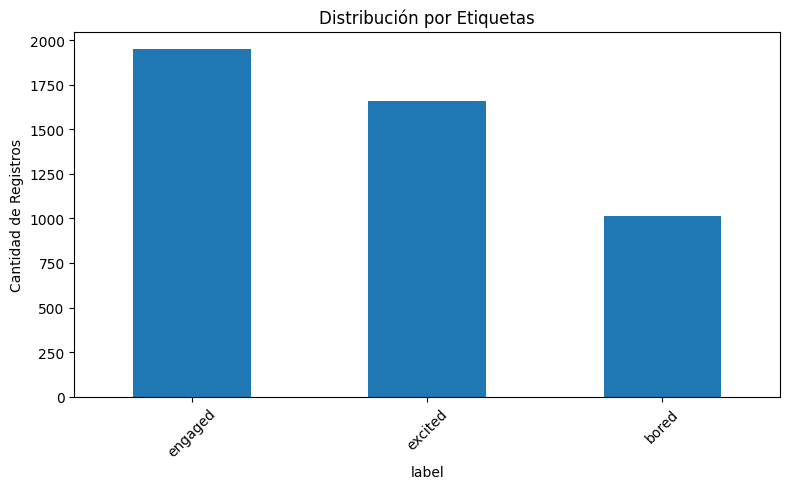

In [11]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiquetas'].value_counts().plot(kind='bar')
plt.xlabel('label')
plt.ylabel('Cantidad de Registros')
plt.title('Distribución por Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
'''
# Redimensionar una imagen
def resize_img(image, new_w, new_h):
    img = Image.fromarray(image)
    img = img.resize((new_w, new_h))
    return np.array(img)

new_w = 150
new_h = 150

# Redimensionar todas las imágenes a la misma forma y convertirlas en arreglos numpy
# Redimensiona w = 150, h = 150
X = np.array([resize_img(imagen, new_w, new_h) for imagen in df['face_closeup']])
'''


# Función para redimensionar una imagen
def redimensionar_imagen(imagen, nuevo_ancho, nuevo_alto):
    img = Image.fromarray(imagen)
    img = img.resize((nuevo_ancho, nuevo_alto))
    return np.array(img)

# Definir el tamaño al que quieres redimensionar todas las imágenes
nuevo_ancho = 150
nuevo_alto = 150

# Redimensionar todas las imágenes a la misma forma y convertirlas en arreglos numpy
X = np.array([redimensionar_imagen(imagen, nuevo_ancho, nuevo_alto) for imagen in df['Imagen con zoom']])

In [13]:
X = X /255.0

In [14]:
#labels = df['label'].astype('category').cat.codes
etiquetas = df['Etiquetas'].astype('category').cat.codes

In [15]:
#print(labels)
print(etiquetas)

0       0
1       0
2       0
3       0
4       0
       ..
4618    2
4619    2
4620    2
4621    2
4622    2
Length: 4623, dtype: int8


In [16]:
#Dividir datos de entrenamiento y validacion

#X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, etiquetas, test_size=0.3, random_state=42)


In [17]:
# Definir el modelo CNN
'''
model = models.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(new_w, new_h, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(labels), activation='softmax')
])'''

model = models.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(nuevo_ancho, nuevo_alto, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(etiquetas), activation='softmax')
])

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 85:
            print("\nReached 85% accuracy so cancelling training!")
            self.model.stop_training = True
            
back = myCallback() 

In [19]:
#compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test),callbacks=[back])

Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "c:\Users\josek\.conda\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\josek\.conda\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\josek\.conda\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\josek\.conda\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\josek\.conda\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\josek\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\josek\AppData\Local\Temp\ipykernel_152888\1083277763.py", line 1, in <module>
      model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test),callbacks=[back])
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[32,256,148,148] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_899]

In [ ]:
# Calcular la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Models accuracy:", test_accuracy)

# Generar la matriz de confusión
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

print("Confusion Matrix:")
print(confusion_mat)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

# Plotear la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


In [ ]:
#import numpy as np
#from PIL import Image

# Cargar y preprocesar la imagen
def cargar_y_preprocesar_imagen(ruta_imagen, nuevo_ancho, nuevo_alto):
    imagen = Image.open(ruta_imagen).convert('L')  # Convertir a escala de grises si es necesario
    imagen = imagen.resize((nuevo_ancho, nuevo_alto))
    imagen_array = np.array(imagen)
    imagen_array = np.expand_dims(imagen_array, axis=0)  # Agregar una dimensión de lote
    imagen_array = np.expand_dims(imagen_array, axis=3)  # Agregar una dimensión de canal (para escala de grises)
    return imagen_array

# Definir la ruta de la imagen a predecir
ruta_imagen = '62.jpeg'

# Cargar y preprocesar la imagen
imagen_array = cargar_y_preprocesar_imagen(ruta_imagen, 150, 150)

# Realizar la predicción
prediccion = model.predict(imagen_array)

# Obtener la clase predicha
clase_predicha = np.argmax(prediccion)

# Imprimir la clase predicha
print("Clase predicha:", clase_predicha)

In [ ]:
model.save('modeloCNN3.h5')